# PROBLEM STATEMEN
Kekhawatiran adanya keterlambatan pembayaran kartu kredit pada FinanKu yang akan merugikan bisnis. Sehingga orang-orang
yang memiliki potensi untuk mengalami potensi keterlambatan bayar bisa diprediksi lebih cepat untuk menentukan strategi yang sesuai dalam menghadapi kodisi dimasa mendatang.

OBJECTIVE
Membuat sebuah model yang dapat memprediksi setidaknya 60% dari pelanggan yang akan mengalami telat bayar kartu kredit (Accuracy & Recall di atas 60%)

# VARIABEL YANG TERSEDIA
Dari dataset yang dimiliki terdapat beberapa data yang tersedia.
_______________________________________________________________________________________________________________________
1.  **Customer ID**: unique ID customer.
2.  **Branch**: lokasi cabang nasabah terdaftar.
3.	**City**: lokasi kota nasabah terdaftar.
4.	**Age**: umur nasabah pada periode observasi.
5.	**Avg**: Annual Income: rata-rata penghasilan nasabah dalam satu tahun.
6.	**Balance (Q1-Q4)**: saldo mengendap yang dimiliki nasabah di akhir kuartal.
7.	**Num of Product (Q1-Q4)**: status kepemilikan produk nasabah yang dimiliki di akhir kuartal.
8.	**HasCrCard (Q1-Q4)**: status kepemilikan produk kartu kredit nasabah di akhir kuartal.
9.	**Active Member (Q1-Q4)**: status keaktifan nasabah.
10.	**Unpaid tagging**: status nasabah gagal bayar.

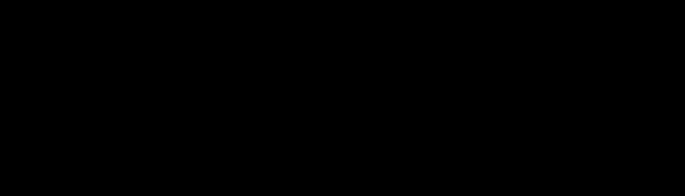
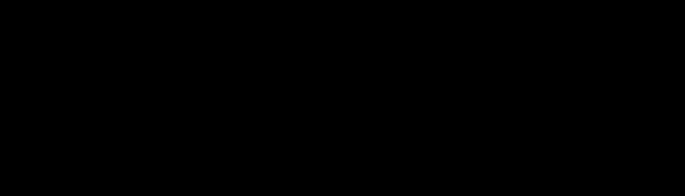

# EXPERIMENT
### Periode Tinjauan
1. Nasabah direview selama satu tahun terakhir
2. Nasabah direview selama 6 bulan terakhir
### Penyesuaian Variabel
1. Balance dilihat dari rata-rata selama horizon waktu & dilihat perubahan pada akhir tinjauan dan awal tinjauan
2. Melihat kepemilikan jumlah produk dari rata-rata, maksimum, dan minimum pada periode tinjauan
3. Status keaktifan nasabah dilihat dalam bentuk bulan

# Import Package

In [214]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score, precision_score, recall_score,  f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from xgboost import XGBClassifier
from jcopml.feature_importance import mean_score_decrease

In [4]:
pd.set_option('display.max_columns', None)

# Data For Prediction

In [46]:
path_1 = "https://raw.githubusercontent.com/brainspopper/dataset/main/FinanKu%20Data%20All.csv"
path_2 = "https://raw.githubusercontent.com/brainspopper/dataset/main/FinanKu%20Data%20Validasi.csv"
df_all = pd.read_csv(path_1)
df_val = pd.read_csv(path_2)

Buat dua dataframe dengan path sama untuk eksperimen

In [47]:
df1 = pd.read_csv(path_1) # untuk eksperimen 1
df2 = pd.read_csv(path_1) # untuk eksperimen 2

In [48]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,...,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,...,0,0.00,1,1,0,1187036.18,1,1,1,1
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,...,0,0.00,2,1,0,0.00,2,1,0,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,...,0,0.00,2,1,0,1351820.24,2,1,1,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,...,0,0.00,2,1,0,0.00,2,1,0,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,...,0,678905.68,2,1,1,431190.68,2,1,1,0


In [49]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,...,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,...,0,0.00,1,1,0,1187036.18,1,1,1,1
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,...,0,0.00,2,1,0,0.00,2,1,0,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,...,0,0.00,2,1,0,1351820.24,2,1,1,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,...,0,0.00,2,1,0,0.00,2,1,0,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,...,0,678905.68,2,1,1,431190.68,2,1,1,0


# Data Understanding
Sebaran nasabah berdasarkan lokasi
   * Sebaran keseluruhan
   * Sebaran nasabah gagal bayar

In [50]:
data1 = pd.DataFrame(\
                      #Mengelompokkan berdasarkan kota
                       df_all.groupby(by=['City'])['Customer ID']\
                      #Diagegatkan dengan menghitung jumlahnya (count)
                       .count()\
                      #Mengurutkan data
                       .sort_values(ascending=False)\
                      #reset nama header
                       .reset_index(name='Distribution by City'))
data1


,City,Distribution by City
0,Surabaya,3767
1,Bandung,1898
2,Jakarta,1896


In [51]:
data2 = pd.DataFrame(\
                        df_all[df_all['Unpaid Tagging']==1].groupby(by=['City'])['Customer ID']
                        .count()\
                        .sort_values(ascending=False)\
                        .reset_index(name='Distribution by City'))
data2

,City,Distribution by City
0,Surabaya,1033
1,Bandung,496
2,Jakarta,490


Sebaran nasabah berdasarkan usia:
 * Sebaran keseluruhan.
  * Sebaran nasabah gagal bayar.

<Axes: title={'center': 'Cust. Distribution by Age'}, xlabel='Age', ylabel='# People'>

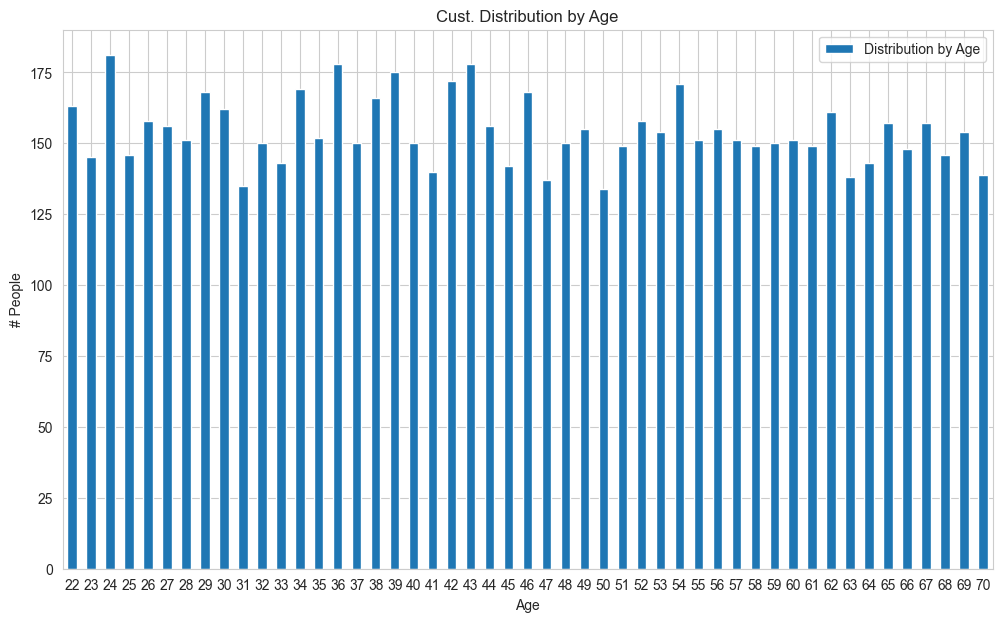

In [52]:
data3 = pd.DataFrame(\
                      #Mengelompokkan berdasarkan usia                      df_all.groupby(by=['Age'])['Customer ID']\
                       df_all.groupby(by=['Age'])['Customer ID']\
                      #Diagegatkan dengan menghitung jumlahnya (count)
                       .count()\
                      #reset nama header
                       .reset_index(name='Distribution by Age'))
data3.sort_values(\
                  by=['Age'], \
                  ascending=True, \
                  inplace=True)
data3.plot(x='Age',
          y=['Distribution by Age'],
          kind='bar',
          grid=True,
          xlabel='Age',
          ylabel='# People',
          figsize=(12,7),
          rot=0,
          title='Cust. Distribution by Age',
          table=False,
          secondary_y = False)

<Axes: title={'center': 'Unpaid Cust. Distribution by Age'}, xlabel='Age', ylabel='# People'>

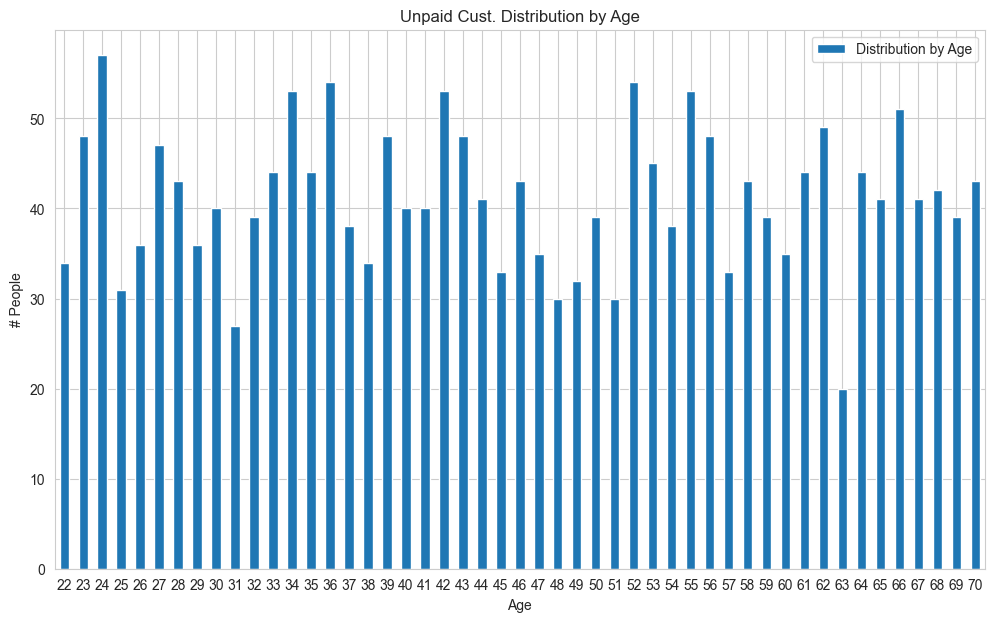

In [53]:
data4 = pd.DataFrame(\
                      #Mengelompokkan berdasarkan usia
                       df_all[df_all['Unpaid Tagging']==1].groupby(by=['Age'])['Customer ID']\
                      #Diagegatkan dengan menghitung jumlahnya (count)
                       .count()\
                      #reset nama header
                       .reset_index(name='Distribution by Age'))
data4.sort_values(\
                  by=['Age'], \
                  ascending=True, \
                  inplace=True)
data4.plot(x='Age',
          y=['Distribution by Age'],
          kind='bar',
          grid=True,
          xlabel='Age',
          ylabel='# People',
          figsize=(12,7),
          rot=0,
          title='Unpaid Cust. Distribution by Age',
          table=False,
          secondary_y = False)

# Rata-rata saldo nasabah

In [54]:
df_checkbalance = df_all
df_checkbalance['Total Balance'] = df_checkbalance['Balance Q1'] + df_checkbalance['Balance Q2'] + df_checkbalance['Balance Q3'] + df_checkbalance['Balance Q4']
df_checkbalance['Avg Balance'] = (df_checkbalance['Balance Q1'] + df_checkbalance['Balance Q2'] + df_checkbalance['Balance Q3'] + df_checkbalance['Balance Q4'])/4

data5 = pd.DataFrame(\
                      df_checkbalance.groupby(by=['Unpaid Tagging'])['Total Balance']\
                      .mean()\
                      .reset_index(name='Avg Annual Balance'))
data5

,Unpaid Tagging,Avg Annual Balance
0,0,1.985924e+08
1,1,2.527238e+08


In [55]:
data6 = pd.DataFrame(\
                      df_checkbalance.groupby(by=['Unpaid Tagging'])['Avg Balance']\
                      .mean()\
                      .reset_index(name='Avg Quarterly Balance'))
data6

,Unpaid Tagging,Avg Quarterly Balance
0,0,4.964809e+07
1,1,6.318095e+07


### Rata-rata kepemilikan produk

In [56]:
df_checkbalance['Avg Product'] = (df_checkbalance['NumOfProducts Q1'] +
                                   df_checkbalance['NumOfProducts Q2'] +
                                   df_checkbalance['NumOfProducts Q3'] +
                                   df_checkbalance['NumOfProducts Q4'])/4
data7 = pd.DataFrame(\
                      df_checkbalance.groupby(by=['Unpaid Tagging'])['Avg Product']\
                      .mean()\
                      .reset_index(name='Avg Product Owned'))
data7

,Unpaid Tagging,Avg Product Owned
0,0,1.667223
1,1,1.609336


In [33]:
df_all = df_all.drop(columns=['Total Balance', 'Avg Balance', 'Avg Product'])

# Data Preparation
## Pengecekan Data Terduplikat

In [57]:
df_all.duplicated().sum()

np.int64(0)

## Pengecekan Missing Data

In [58]:
df_all.isnull().sum()

Customer ID                 0
Branch Code                 0
City                        0
Age                         0
Avg. Annual Income/Month    0
Balance Q1                  0
NumOfProducts Q1            0
HasCrCard Q1                0
ActiveMember Q1             0
Balance Q2                  0
NumOfProducts Q2            0
HasCrCard Q2                0
ActiveMember Q2             0
Balance Q3                  0
NumOfProducts Q3            0
HasCrCard Q3                0
ActiveMember Q3             0
Balance Q4                  0
NumOfProducts Q4            0
HasCrCard Q4                0
ActiveMember Q4             0
Unpaid Tagging              0
Total Balance               0
Avg Balance                 0
Avg Product                 0
dtype: int64

# Penambahan Variabel Relevan
### Rata-rata Saldo & Perubaahan Saldo Selama Periode Observasi

Melihat saldo nasabah dalam scope observasi
1. Experimen 1: Rata-rata saldo nasabah dalam 1 tahun terakhir & Perubahan Saldo di Q4 terhadap Q1
2. Experimen 2: Rata-rata saldo nasabah dalam 6 bulan terakhir & perubahan Saldo di Q4 terhadap Q2

## Eksperimen 1

In [59]:
df1['Mean Balance'] = (df1['Balance Q1'] + df1['Balance Q2'] + df1['Balance Q3'] + df1['Balance Q4'])/4
df1['Delta Balance'] = df1['Balance Q4'] - df1['Balance Q1']
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,...,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,...,1,1,0,1187036.18,1,1,1,1,296759.045,1187036.18
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,...,2,1,0,0.00,2,1,0,0,0.000,0.00
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,...,2,1,0,1351820.24,2,1,1,0,337955.060,1351820.24
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,...,2,1,0,0.00,2,1,0,0,0.000,0.00
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,...,2,1,1,431190.68,2,1,1,0,277524.090,431190.68


## Eksperimen 2

In [60]:
df2['Mean Balance']= (df2['Balance Q3'] + df2['Balance Q4'])/2
df2['Delta Balance'] = df2['Balance Q4'] - df2['Balance Q2']
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,...,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,...,1,1,0,1187036.18,1,1,1,1,593518.09,1187036.18
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,...,2,1,0,0.00,2,1,0,0,0.00,0.00
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,...,2,1,0,1351820.24,2,1,1,0,675910.12,1351820.24
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,...,2,1,0,0.00,2,1,0,0,0.00,0.00
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,...,2,1,1,431190.68,2,1,1,0,555048.18,431190.68


# Status Keaktifan
Melihat Periode nasabah aktif dalam scope observasi
1. Experiment 1 --> Keaktifan nasabah (dalam bulan) di 1 tahun terakhir
2. Experiment 2 --> Keaktifan ansabah (dalam bulan) di 6 bulan terakhir

## Experiment 1

In [61]:
df1['Active Months'] = (df1['ActiveMember Q1']+df1['ActiveMember Q2']+df1['ActiveMember Q3']+df1['ActiveMember Q4'])*3

In [62]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,...,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,...,1,0,1187036.18,1,1,1,1,296759.045,1187036.18,6
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,...,1,0,0.00,2,1,0,0,0.000,0.00,3
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,...,1,0,1351820.24,2,1,1,0,337955.060,1351820.24,3
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,...,1,0,0.00,2,1,0,0,0.000,0.00,3
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,...,1,1,431190.68,2,1,1,0,277524.090,431190.68,6


## Experiment 2

In [63]:
df2['Active Months'] = (df2['ActiveMember Q3']+df2['ActiveMember Q4'])*3
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,...,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,...,1,0,1187036.18,1,1,1,1,593518.09,1187036.18,3
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,...,1,0,0.00,2,1,0,0,0.00,0.00,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,...,1,0,1351820.24,2,1,1,0,675910.12,1351820.24,3
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,...,1,0,0.00,2,1,0,0,0.00,0.00,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,...,1,1,431190.68,2,1,1,0,555048.18,431190.68,6


# Penambahan atau Pengurangan Product Holding
Melihat fluktuasi kepemilikan produk nasabah dalam periode observasi
## Eksperimen 1

In [64]:
df1['Diff PH'] = df1['NumOfProducts Q4'] - df1['NumOfProducts Q1']
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,...,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,...,0,1187036.18,1,1,1,1,296759.045,1187036.18,6,0
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,...,0,0.00,2,1,0,0,0.000,0.00,3,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,...,0,1351820.24,2,1,1,0,337955.060,1351820.24,3,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,...,0,0.00,2,1,0,0,0.000,0.00,3,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,...,1,431190.68,2,1,1,0,277524.090,431190.68,6,0


## Eksperimen 2

In [65]:
df2['Diff PH'] = df2['NumOfProducts Q4'] - df2['NumOfProducts Q2']
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,...,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,...,0,1187036.18,1,1,1,1,593518.09,1187036.18,3,0
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,...,0,0.00,2,1,0,0,0.00,0.00,0,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,...,0,1351820.24,2,1,1,0,675910.12,1351820.24,3,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,...,0,0.00,2,1,0,0,0.00,0.00,0,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,...,1,431190.68,2,1,1,0,555048.18,431190.68,6,0


## Lama Kepemilikan Kartu Kredit dalam Periode Observasi

In [66]:
def assign_cr1(df):
  if df['HasCrCard Q1'] == 1:
    return 12
  elif df['HasCrCard Q2'] == 1:
    return 9
  elif df['HasCrCard Q3'] == 1:
    return 6
  else:
    return 3
  return np.nan

## Experiment 1

In [67]:
df1['Vintage_CR'] = df1.apply(assign_cr1, axis=1)

In [68]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,...,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,...,1187036.18,1,1,1,1,296759.045,1187036.18,6,0,12
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,...,0.00,2,1,0,0,0.000,0.00,3,0,12
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,...,1351820.24,2,1,1,0,337955.060,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,...,0.00,2,1,0,0,0.000,0.00,3,0,12
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,...,431190.68,2,1,1,0,277524.090,431190.68,6,0,12


## Experiment 2

In [69]:
df2['Vintage_CR'] = df2.apply(assign_cr1, axis=1)


In [70]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,...,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,...,1187036.18,1,1,1,1,593518.09,1187036.18,3,0,12
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,...,0.00,2,1,0,0,0.00,0.00,0,0,12
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,...,1351820.24,2,1,1,0,675910.12,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,...,0.00,2,1,0,0,0.00,0.00,0,0,12
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,...,431190.68,2,1,1,0,555048.18,431190.68,6,0,12


# Penghapusan Variabel
Status kepemilikan sudah digantikan dengan lama kepemilikan kartu kredit

In [71]:
df1 = df1.drop(columns = ['HasCrCard Q1', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4'], errors='ignore')
df2 = df2.drop(columns = ['HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4', 'HasCrCard Q5'], errors='ignore')

In [72]:
print(df1.columns)
print(df2.columns)

Index(['Customer ID', 'Branch Code', 'City', 'Age', 'Avg. Annual Income/Month',
       'Balance Q1', 'NumOfProducts Q1', 'ActiveMember Q1', 'Balance Q2',
       'NumOfProducts Q2', 'ActiveMember Q2', 'Balance Q3', 'NumOfProducts Q3',
       'ActiveMember Q3', 'Balance Q4', 'NumOfProducts Q4', 'ActiveMember Q4',
       'Unpaid Tagging', 'Mean Balance', 'Delta Balance', 'Active Months',
       'Diff PH', 'Vintage_CR'],
      dtype='str')
Index(['Customer ID', 'Branch Code', 'City', 'Age', 'Avg. Annual Income/Month',
       'Balance Q1', 'NumOfProducts Q1', 'HasCrCard Q1', 'ActiveMember Q1',
       'Balance Q2', 'NumOfProducts Q2', 'ActiveMember Q2', 'Balance Q3',
       'NumOfProducts Q3', 'ActiveMember Q3', 'Balance Q4', 'NumOfProducts Q4',
       'ActiveMember Q4', 'Unpaid Tagging', 'Mean Balance', 'Delta Balance',
       'Active Months', 'Diff PH', 'Vintage_CR'],
      dtype='str')


In [73]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,...,ActiveMember Q3,Balance Q4,NumOfProducts Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,0.0,1,...,0,1187036.18,1,1,1,296759.045,1187036.18,6,0,12
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,0.0,2,...,0,0.00,2,0,0,0.000,0.00,3,0,12
2,15566091,1009,Jakarta,25,12000000,0.0,2,0,0.0,2,...,0,1351820.24,2,1,0,337955.060,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,0.0,2,...,0,0.00,2,0,0,0.000,0.00,3,0,12
4,15566312,1009,Jakarta,43,29000000,0.0,2,0,0.0,2,...,1,431190.68,2,1,0,277524.090,431190.68,6,0,12


In [74]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,...,ActiveMember Q3,Balance Q4,NumOfProducts Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,...,0,1187036.18,1,1,1,593518.09,1187036.18,3,0,12
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,...,0,0.00,2,0,0,0.00,0.00,0,0,12
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,...,0,1351820.24,2,1,0,675910.12,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,...,0,0.00,2,0,0,0.00,0.00,0,0,12
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,...,1,431190.68,2,1,0,555048.18,431190.68,6,0,12


Balance Per Quarter sudah digantikan dengan rata-rata Saldo dalam periode observasi & selisih saldo di awal dan akhir periode obsevarsi

In [75]:
df1 = df1.drop(columns = ['Balance Q1', 'Balance Q2', 'Balance Q3', 'Balance Q4'], errors='ignore')
df2 = df2.drop(columns = ['Balance Q1', 'Balance Q2', 'Balance Q3', 'Balance Q4'], errors='ignore')

Jumlah Kepemilikan Produk sudah digantikan dengan fluktuasi kepemilikan produk pada periode observasi

In [76]:
df1 = df1.drop(columns = ['NumOfProducts Q1','NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4'], errors='ignore')
df2 = df2.drop(columns = ['NumOfProducts Q1','NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4'], errors='ignore')

In [78]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,ActiveMember Q1,ActiveMember Q2,ActiveMember Q3,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,1,0,0,1,1,296759.045,1187036.18,6,0,12
1,15565878,1005,Jakarta,68,17000000,1,0,0,0,0,0.000,0.00,3,0,12
2,15566091,1009,Jakarta,25,12000000,0,0,0,1,0,337955.060,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,1,0,0,0,0,0.000,0.00,3,0,12
4,15566312,1009,Jakarta,43,29000000,0,0,1,1,0,277524.090,431190.68,6,0,12


In [79]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,HasCrCard Q1,ActiveMember Q1,ActiveMember Q2,ActiveMember Q3,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,1,1,0,0,1,1,593518.09,1187036.18,3,0,12
1,15565878,1005,Jakarta,68,17000000,1,1,0,0,0,0,0.00,0.00,0,0,12
2,15566091,1009,Jakarta,25,12000000,1,0,0,0,1,0,675910.12,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,1,1,0,0,0,0,0.00,0.00,0,0,12
4,15566312,1009,Jakarta,43,29000000,1,0,0,1,1,0,555048.18,431190.68,6,0,12


Status Keaktifan Nasabah Per Quarter digantikan dengan Status Keaktifan dalam Bulan

In [80]:
df1 = df1.drop(columns = ['ActiveMember Q1', 'ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'], errors='ignore')
df2 = df2.drop(columns = ['ActiveMember Q1', 'ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'], errors='ignore')

In [82]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,1,296759.045,1187036.18,6,0,12
1,15565878,1005,Jakarta,68,17000000,0,0.000,0.00,3,0,12
2,15566091,1009,Jakarta,25,12000000,0,337955.060,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,0,0.000,0.00,3,0,12
4,15566312,1009,Jakarta,43,29000000,0,277524.090,431190.68,6,0,12


In [81]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,HasCrCard Q1,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,1,1,593518.09,1187036.18,3,0,12
1,15565878,1005,Jakarta,68,17000000,1,0,0.00,0.00,0,0,12
2,15566091,1009,Jakarta,25,12000000,1,0,675910.12,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,1,0,0.00,0.00,0,0,12
4,15566312,1009,Jakarta,43,29000000,1,0,555048.18,431190.68,6,0,12


# Data Transformastion

In [83]:
predictor1 = df1[df1.columns.difference(['Customer ID', 'Unpaid Tagging'])]
predictor2 = df2[df2.columns.difference(['Customer ID', 'Unpaid Tagging'])]

In [84]:
predictor1.head()

,Active Months,Age,Avg. Annual Income/Month,Branch Code,City,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,6,29,33000000,1001,Jakarta,1187036.18,0,296759.045,12
1,3,68,17000000,1005,Jakarta,0.00,0,0.000,12
2,3,25,12000000,1009,Jakarta,1351820.24,0,337955.060,12
3,3,42,19000000,1008,Jakarta,0.00,0,0.000,12
4,6,43,29000000,1009,Jakarta,431190.68,0,277524.090,12


In [178]:
print(df1.columns)
print(df2.columns)

In [85]:
predictor2.head()

,Active Months,Age,Avg. Annual Income/Month,Branch Code,City,Delta Balance,Diff PH,HasCrCard Q1,Mean Balance,Vintage_CR
0,3,29,33000000,1001,Jakarta,1187036.18,0,1,593518.09,12
1,0,68,17000000,1005,Jakarta,0.00,0,1,0.00,12
2,3,25,12000000,1009,Jakarta,1351820.24,0,1,675910.12,12
3,0,42,19000000,1008,Jakarta,0.00,0,1,0.00,12
4,6,43,29000000,1009,Jakarta,431190.68,0,1,555048.18,12


### Melakukan Encoding untuk Data Category
1. Branch Code
2. City

In [86]:
predictor1['Branch Code'] = predictor1['Branch Code'].astype(str)
predictor2['Branch Code'] = predictor2['Branch Code'].astype(str)

In [87]:
predictor1.info()

<class 'pandas.DataFrame'>
RangeIndex: 7561 entries, 0 to 7560
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Active Months             7561 non-null   int64  
 1   Age                       7561 non-null   int64  
 2   Avg. Annual Income/Month  7561 non-null   int64  
 3   Branch Code               7561 non-null   str    
 4   City                      7561 non-null   str    
 5   Delta Balance             7561 non-null   float64
 6   Diff PH                   7561 non-null   int64  
 7   Mean Balance              7561 non-null   float64
 8   Vintage_CR                7561 non-null   int64  
dtypes: float64(2), int64(5), str(2)
memory usage: 531.8 KB


In [88]:
predictor2.info()

<class 'pandas.DataFrame'>
RangeIndex: 7561 entries, 0 to 7560
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Active Months             7561 non-null   int64  
 1   Age                       7561 non-null   int64  
 2   Avg. Annual Income/Month  7561 non-null   int64  
 3   Branch Code               7561 non-null   str    
 4   City                      7561 non-null   str    
 5   Delta Balance             7561 non-null   float64
 6   Diff PH                   7561 non-null   int64  
 7   HasCrCard Q1              7561 non-null   int64  
 8   Mean Balance              7561 non-null   float64
 9   Vintage_CR                7561 non-null   int64  
dtypes: float64(2), int64(6), str(2)
memory usage: 590.8 KB


In [89]:
predictor1 = pd.get_dummies(predictor1)
predictor2 = pd.get_dummies(predictor2)

In [90]:
predictor1.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,...,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,6,29,33000000,1187036.18,0,296759.045,12,True,False,False,...,False,False,False,False,False,False,False,False,True,False
1,3,68,17000000,0.00,0,0.000,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,3,25,12000000,1351820.24,0,337955.060,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,3,42,19000000,0.00,0,0.000,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,6,43,29000000,431190.68,0,277524.090,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [91]:
predictor2.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,HasCrCard Q1,Mean Balance,Vintage_CR,Branch Code_1001,Branch Code_1002,...,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,3,29,33000000,1187036.18,0,1,593518.09,12,True,False,...,False,False,False,False,False,False,False,False,True,False
1,0,68,17000000,0.00,0,1,0.00,12,False,False,...,False,False,False,False,False,False,False,False,True,False
2,3,25,12000000,1351820.24,0,1,675910.12,12,False,False,...,False,False,False,False,False,False,False,False,True,False
3,0,42,19000000,0.00,0,1,0.00,12,False,False,...,False,False,False,False,False,False,False,False,True,False
4,6,43,29000000,431190.68,0,1,555048.18,12,False,False,...,False,False,False,False,False,False,False,False,True,False


Simpan nama dari setiap column

In [93]:
predname = predictor1.columns
predname_num = predictor1.columns[0:7]
predname_cat = predictor1.columns[7:31]

In [94]:
predname

Index(['Active Months', 'Age', 'Avg. Annual Income/Month', 'Delta Balance',
       'Diff PH', 'Mean Balance', 'Vintage_CR', 'Branch Code_1001',
       'Branch Code_1002', 'Branch Code_1003', 'Branch Code_1004',
       'Branch Code_1005', 'Branch Code_1006', 'Branch Code_1007',
       'Branch Code_1008', 'Branch Code_1009', 'Branch Code_1011',
       'Branch Code_1012', 'Branch Code_1013', 'Branch Code_1014',
       'Branch Code_1015', 'Branch Code_1021', 'Branch Code_1022',
       'Branch Code_1023', 'Branch Code_1024', 'City_Bandung', 'City_Jakarta',
       'City_Surabaya'],
      dtype='str')

In [95]:
predname_num

Index(['Active Months', 'Age', 'Avg. Annual Income/Month', 'Delta Balance',
       'Diff PH', 'Mean Balance', 'Vintage_CR'],
      dtype='str')

In [96]:
predname_cat

Index(['Branch Code_1001', 'Branch Code_1002', 'Branch Code_1003',
       'Branch Code_1004', 'Branch Code_1005', 'Branch Code_1006',
       'Branch Code_1007', 'Branch Code_1008', 'Branch Code_1009',
       'Branch Code_1011', 'Branch Code_1012', 'Branch Code_1013',
       'Branch Code_1014', 'Branch Code_1015', 'Branch Code_1021',
       'Branch Code_1022', 'Branch Code_1023', 'Branch Code_1024',
       'City_Bandung', 'City_Jakarta', 'City_Surabaya'],
      dtype='str')

In [97]:
X1_num = predictor1[predname_num]
X2_num = predictor2[predname_num]
X1_cat = predictor1[predname_cat]
X2_cat = predictor2[predname_cat]

### Standarisasi data numerik

In [102]:
from sklearn.preprocessing import StandardScaler
pt = StandardScaler()
X1_num = pd.DataFrame(pt.fit_transform(X1_num))
X1_num.head()

,0,1,2,3,4,5,6
0,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [99]:
X1_num.columns = predname_num
X1_num.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [100]:
X2_num = pd.DataFrame(pt.fit_transform(X2_num))
X2_num.head()

,0,1,2,3,4,5,6
0,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


In [101]:
X2_num.columns = predname_num
X2_num.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


# Menggabungkan Dataset Prediktor

In [104]:
X1 = pd.concat([X1_cat, X1_num], axis=1)
X2 = pd.concat([X2_cat, X2_num], axis=1)

In [105]:
X1.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,...,City_Bandung,City_Jakarta,City_Surabaya,0,1,2,3,4,5,6
0,True,False,False,False,False,False,False,False,False,False,...,False,True,False,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,False,False,False,False,True,False,False,False,False,False,...,False,True,False,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,False,False,False,False,False,False,False,False,True,False,...,False,True,False,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,False,False,False,False,False,False,False,True,False,False,...,False,True,False,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,False,False,False,False,False,False,False,False,True,False,...,False,True,False,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [106]:
X2.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,...,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,True,False,False,False,False,False,False,False,False,False,...,False,True,False,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,False,False,False,False,True,False,False,False,False,False,...,False,True,False,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,False,False,False,False,False,False,False,False,True,False,...,False,True,False,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,False,False,False,False,False,False,False,True,False,False,...,False,True,False,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,False,False,False,False,False,False,False,False,True,False,...,False,True,False,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


### Variabel dependen

In [107]:
y1 = df1['Unpaid Tagging']
y2 = df2['Unpaid Tagging']

# Mempersiapkan Dataset untuk Valiasi

## Import Data

In [108]:
df1_val = pd.read_csv(path_2) #untuk eksperimen 1
df2_val = pd.read_csv(path_2) #untuk eksperimen 2

## Penambahan Variabel Relevan
Rata-rata *balance* dan perubahan saldo

In [112]:
df1_val['Mean Balance'] = (df1_val['Balance Q2']+df1_val['Balance Q3']+df1_val['Balance Q4']+df1_val['Balance Q5'])/4
df2_val['Mean Balance'] = (df2_val['Balance Q4']+df1_val['Balance Q5'])/2

In [113]:
df1_val['Delta Balance'] = df1_val['Balance Q5']-df1_val['Balance Q2']
df2_val['Delta Balance'] = df2_val['Balance Q5']-df2_val['Balance Q4']

## Status Keaktifan

In [114]:
df1_val['Active Months'] = (df1_val['ActiveMember Q2']+df1_val['ActiveMember Q3']+df1_val['ActiveMember Q4']+df1_val['ActiveMember Q5'])*3
df2_val['Active Months'] = (df2_val['ActiveMember Q4']+df1_val['ActiveMember Q5'])*3

## Penambahan/Pengurangan Product Holding

In [115]:
df1_val['Diff PH'] = df1_val['NumOfProducts Q5']-df1_val['NumOfProducts Q2']
df2_val['Diff PH'] = df2_val['NumOfProducts Q5']-df1_val['NumOfProducts Q3']

## Lama Kepemilikan Kartu Kredit

In [116]:
def assign_cr2(df):
    if df['HasCrCard Q2'] == 1:
        return 12
    elif df['HasCrCard Q3'] == 1:
        return 9
    elif df['HasCrCard Q4'] == 1:
        return 6
    else:
        return 3
    return np.nan

In [117]:
df1_val['Vintage_CR'] = df1_val.apply(assign_cr2, axis=1)
df2_val['Vintage_CR'] = df2_val.apply(assign_cr2, axis=1)

In [119]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,1,296759.045,1187036.18,6,0,12
1,15565878,1005,Jakarta,68,17000000,0,0.000,0.00,3,0,12
2,15566091,1009,Jakarta,25,12000000,0,337955.060,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,0,0.000,0.00,3,0,12
4,15566312,1009,Jakarta,43,29000000,0,277524.090,431190.68,6,0,12


In [120]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,HasCrCard Q1,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,1,1,593518.09,1187036.18,3,0,12
1,15565878,1005,Jakarta,68,17000000,1,0,0.00,0.00,0,0,12
2,15566091,1009,Jakarta,25,12000000,1,0,675910.12,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,1,0,0.00,0.00,0,0,12
4,15566312,1009,Jakarta,43,29000000,1,0,555048.18,431190.68,6,0,12


## Penghapusan Variabel

In [129]:
df1_val = df1_val.drop(columns = ['HasCrCard Q5', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4', 'Balance Q5', 'Balance Q2', 'Balance Q3', 'Balance Q4', 'NumOfProducts Q5', 'NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4', 'ActiveMember Q5', 'ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'], errors='ignore')
df2_val = df2_val.drop(columns = ['HasCrCard Q5', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4', 'Balance Q5', 'Balance Q2', 'Balance Q3', 'Balance Q4', 'NumOfProducts Q5', 'NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4', 'ActiveMember Q5', 'ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'], errors='ignore')

In [130]:
df1_val.head(10)

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,1,6.231940e+05,1.305740e+06,6,0,12
1,15565878,1005,Jakarta,68,17000000,1,0.000000e+00,0.000000e+00,0,0,12
2,15566091,1009,Jakarta,25,12000000,0,7.435011e+05,1.622184e+06,6,0,12
3,15566292,1008,Jakarta,42,19000000,1,0.000000e+00,0.000000e+00,0,2,12
4,15566312,1009,Jakarta,43,29000000,0,3.853218e+05,4.311907e+05,6,1,12
5,15566495,1005,Jakarta,27,15000000,0,5.647607e+07,1.365946e+07,9,0,12
6,15566543,1003,Jakarta,68,26000000,0,1.234332e+08,5.441502e+07,9,2,12
7,15566594,1008,Jakarta,61,24000000,1,0.000000e+00,0.000000e+00,0,0,12
8,15566689,1003,Jakarta,43,38000000,0,2.247047e+05,2.996062e+05,3,1,12
9,15566958,1005,Jakarta,70,23000000,0,8.243379e+07,1.169147e+07,9,0,6


In [131]:
df2_val.head(10)

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,1,1.246388e+06,1.187036e+05,6,0,12
1,15565878,1005,Jakarta,68,17000000,1,0.000000e+00,0.000000e+00,0,0,12
2,15566091,1009,Jakarta,25,12000000,0,1.487002e+06,2.703640e+05,6,0,12
3,15566292,1008,Jakarta,42,19000000,1,0.000000e+00,0.000000e+00,0,2,12
4,15566312,1009,Jakarta,43,29000000,0,4.311907e+05,0.000000e+00,3,1,12
5,15566495,1005,Jakarta,27,15000000,0,5.990946e+07,1.331321e+07,6,0,12
6,15566543,1003,Jakarta,68,26000000,0,1.370369e+08,5.481477e+07,3,1,12
7,15566594,1008,Jakarta,61,24000000,1,0.000000e+00,0.000000e+00,0,0,12
8,15566689,1003,Jakarta,43,38000000,0,2.996062e+05,0.000000e+00,0,1,12
9,15566958,1005,Jakarta,70,23000000,0,8.535666e+07,1.191023e+07,3,0,6


## Pemilihan Variabel Prediktor

In [155]:
predictor1_val = df1_val[df1_val.columns.difference(['Customer ID', 'Unpaid Tagging'])]
predictor2_val = df2_val[df2_val.columns.difference(['Customer ID', 'Unpaid Tagging'])]

In [156]:
predictor1_val['Branch Code'] = predictor1_val['Branch Code'].astype(str)
predictor2_val['Branch Code'] = predictor2_val['Branch Code'].astype(str)

In [158]:
predictor1_val = pd.get_dummies(predictor1_val)
predictor2_val = pd.get_dummies(predictor2_val)

In [159]:
predictor1_val.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,...,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,6,29,33000000,1305739.798,0,623193.9945,12,True,False,False,...,False,False,False,False,False,False,False,False,True,False
1,0,68,17000000,0.000,0,0.0000,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,6,25,12000000,1622184.288,0,743501.1320,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,0,42,19000000,0.000,2,0.0000,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,6,43,29000000,431190.680,1,385321.7600,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [160]:
predictor2_val.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,...,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,6,29,33000000,118703.618,0,1246387.989,12,True,False,False,...,False,False,False,False,False,False,False,False,True,False
1,0,68,17000000,0.000,0,0.000,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,6,25,12000000,270364.048,0,1487002.264,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,0,42,19000000,0.000,2,0.000,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,3,43,29000000,0.000,1,431190.680,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [161]:
X1_num_val = predictor1_val[predname_num]
X2_num_val = predictor2_val[predname_num]
X1_cat_val = predictor1_val[predname_cat]
X2_cat_val = predictor2_val[predname_cat]

In [174]:
X1_num_val = pd.DataFrame(pt.fit_transform(X1_num_val))
X1_num_val.columns = predname_num

X2_num_val = pd.DataFrame(pt.fit_transform(X2_num_val))
X2_num_val.columns = predname_num

In [175]:
X1_val = pd.concat([X1_cat, X1_num], axis=1)
X2_val = pd.concat([X2_cat, X2_num], axis=1)

In [176]:
X1_num.head()

,0,1,2,3,4,5,6
0,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [178]:
#variabel dependen
y1_val = df1_val['Unpaid Tagging']
y2_val = df2_val['Unpaid Tagging']


# Pengecekan Korelasi
variabel yang berkolerasi lebih dari 0.7 akan di drop

In [180]:
corrtest1 = X1.corr().abs()
corrtest2 = X2.corr().abs()

In [183]:
corrtest1

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,...,City_Bandung,City_Jakarta,City_Surabaya,0,1,2,3,4,5,6
Branch Code_1001,1.000000,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,0.028707,0.040203,...,0.098089,0.292872,0.168829,0.000365,0.010394,0.003603,0.001462,0.003888,0.009732,0.020774
Branch Code_1002,0.028917,1.000000,0.029128,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,...,0.098804,0.295007,0.170060,0.007664,0.006371,0.016078,0.004592,0.003957,0.005634,0.034256
Branch Code_1003,0.028917,0.029128,1.000000,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,...,0.098804,0.295007,0.170060,0.018168,0.013724,0.001937,0.008577,0.004227,0.001776,0.021341
Branch Code_1004,0.029673,0.029889,0.029889,1.000000,0.030318,0.028570,0.028941,0.029163,0.029673,0.041555,...,0.101388,0.302721,0.174506,0.001120,0.008420,0.002095,0.015427,0.001172,0.013269,0.003376
Branch Code_1005,0.029331,0.029545,0.029545,0.030318,1.000000,0.028241,0.028608,0.028827,0.029331,0.041076,...,0.100221,0.299236,0.172498,0.011655,0.001335,0.008829,0.010599,0.001569,0.007520,0.002246
Branch Code_1006,0.027640,0.027842,0.027842,0.028570,0.028241,1.000000,0.026959,0.027165,0.027640,0.038708,...,0.094442,0.281983,0.162551,0.006704,0.004534,0.007488,0.000112,0.017499,0.004003,0.008669
Branch Code_1007,0.028000,0.028204,0.028204,0.028941,0.028608,0.026959,1.000000,0.027518,0.028000,0.039212,...,0.095672,0.285654,0.164668,0.010148,0.011408,0.024003,0.002511,0.018648,0.006408,0.003749
Branch Code_1008,0.028214,0.028420,0.028420,0.029163,0.028827,0.027165,0.027518,1.000000,0.028214,0.039511,...,0.096403,0.287836,0.165926,0.000426,0.005992,0.000678,0.003350,0.006413,0.001808,0.016428
Branch Code_1009,0.028707,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,1.000000,0.040203,...,0.098089,0.292872,0.168829,0.002480,0.002933,0.012510,0.001391,0.012129,0.005874,0.014582
Branch Code_1011,0.040203,0.040496,0.040496,0.041555,0.041076,0.038708,0.039212,0.039511,0.040203,1.000000,...,0.409857,0.137270,0.236432,0.001055,0.011252,0.016018,0.025531,0.004062,0.005530,0.020666


In [182]:
corrtest2

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,...,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
Branch Code_1001,1.000000,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,0.028707,0.040203,...,0.098089,0.292872,0.168829,0.007562,0.010394,0.003603,0.010657,0.002625,0.009749,0.020774
Branch Code_1002,0.028917,1.000000,0.029128,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,...,0.098804,0.295007,0.170060,0.011636,0.006371,0.016078,0.001174,0.000411,0.005640,0.034256
Branch Code_1003,0.028917,0.029128,1.000000,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,...,0.098804,0.295007,0.170060,0.011636,0.013724,0.001937,0.016142,0.007450,0.001736,0.021341
Branch Code_1004,0.029673,0.029889,0.029889,1.000000,0.030318,0.028570,0.028941,0.029163,0.029673,0.041555,...,0.101388,0.302721,0.174506,0.007556,0.008420,0.002095,0.023383,0.007340,0.013205,0.003376
Branch Code_1005,0.029331,0.029545,0.029545,0.030318,1.000000,0.028241,0.028608,0.028827,0.029331,0.041076,...,0.100221,0.299236,0.172498,0.009181,0.001335,0.008829,0.010614,0.003334,0.007493,0.002246
Branch Code_1006,0.027640,0.027842,0.027842,0.028570,0.028241,1.000000,0.026959,0.027165,0.027640,0.038708,...,0.094442,0.281983,0.162551,0.002050,0.004534,0.007488,0.007557,0.002061,0.004017,0.008669
Branch Code_1007,0.028000,0.028204,0.028204,0.028941,0.028608,0.026959,1.000000,0.027518,0.028000,0.039212,...,0.095672,0.285654,0.164668,0.013401,0.011408,0.024003,0.002299,0.018009,0.006425,0.003749
Branch Code_1008,0.028214,0.028420,0.028420,0.029163,0.028827,0.027165,0.027518,1.000000,0.028214,0.039511,...,0.096403,0.287836,0.165926,0.005226,0.005992,0.000678,0.009595,0.012922,0.001792,0.016428
Branch Code_1009,0.028707,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,1.000000,0.040203,...,0.098089,0.292872,0.168829,0.002926,0.002933,0.012510,0.002003,0.022414,0.005889,0.014582
Branch Code_1011,0.040203,0.040496,0.040496,0.041555,0.041076,0.038708,0.039212,0.039511,0.040203,1.000000,...,0.409857,0.137270,0.236432,0.002436,0.011252,0.016018,0.021118,0.012993,0.005449,0.020666


In [185]:
#Membuang niai redundan pada meriks
upper1 = corrtest1.where(np.triu(np.ones(corrtest1.shape), k=1).astype(bool))
upper2 = corrtest2.where(np.triu(np.ones(corrtest1.shape), k=1).astype(bool))

#Mencari nilai yang berkolearasi di atas 0.7
to_drop1 = [column for column in upper1.columns if any(upper1[column] > 0.7)]
to_drop2 = [column for column in upper2.columns if any(upper2[column] > 0.7)]

#Menghapus kolom yang korelasinya > 0.7
X1 = X1.drop(to_drop1, axis=1)
X2 = X2.drop(to_drop2, axis=1)
X1_val = X1_val.drop(to_drop1, axis=1)
X2_val = X2_val.drop(to_drop2, axis=1)


In [186]:
X1.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,...,City_Bandung,City_Jakarta,City_Surabaya,0,1,2,3,4,5,6
0,True,False,False,False,False,False,False,False,False,False,...,False,True,False,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,False,False,False,False,True,False,False,False,False,False,...,False,True,False,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,False,False,False,False,False,False,False,False,True,False,...,False,True,False,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,False,False,False,False,False,False,False,True,False,False,...,False,True,False,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,False,False,False,False,False,False,False,False,True,False,...,False,True,False,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


## *Splitting Tran & Test Data*

In [192]:
y1.value_counts()
y2.value_counts()

Unpaid Tagging
0    5542
1    2019
Name: count, dtype: int64

In [194]:
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, stratify=y1, random_state=30)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, stratify=y2, random_state=30)

# Modelling
Pembangunan model akan menggunakan 3 algoritma:
1. *Logistic Regression*
2. *Gradient Boosting*
3. *Random Forest*


### *#1 Logistic Regresion*
Melakukan definisi *hyperparamter*

In [227]:
penalty = ['l2']
tol = [0.001, 0.0001, 0.00001]
C = [100.0, 10.0, 1.00, 0.1, 0.001]
fit_intercept = [True, False]
intercept_scaling = [1.0, 0.75, 0.5, 0.25]
class_weight = ['balanced', None]
solver = ['newton-cg', 'sag', 'lbfgs', 'saga']
max_iter = [14000]
param_distribution = dict(penalty=penalty, tol=tol, fit_intercept=fit_intercept,
                           intercept_scaling=intercept_scaling, class_weight=class_weight,
                            solver=solver, max_iter = max_iter)

### Melakukan Pencarian *Hyperparameter* terbaik

## Ekperimen 1

In [228]:
#Cross validation
logreg = LogisticRegression()
grid = GridSearchCV(estimator=logreg, param_grid = param_distribution, scoring = 'recall', cv = 5, n_jobs=-1)

start_time = time.time()
grid_result = grid.fit(X1_train.values, y1_train)

#Summarize result
print('Best: %f using %s' %(grid_result.best_score_, grid_result.best_params_))
print('Exection time: ' + str((time.time() - start_time)) + ' s')

Best: 0.416147 using {'class_weight': 'balanced', 'fit_intercept': False, 'intercept_scaling': 1.0, 'max_iter': 14000, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.0001}
Exection time: 8.833313226699829 s


C:\Users\gombe\OneDrive\Desktop\Prediksi Gagal Bayar\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


## Eksperimen 2

In [229]:
#Cross validation
logreg = LogisticRegression()
grid2 = GridSearchCV(estimator=logreg, param_grid = param_distribution, scoring = 'recall', cv = 5, n_jobs=-1)

start_time = time.time()
grid_result = grid2.fit(X1_train.values, y1_train)

#Summarize results
print('Best: %f using %s' %(grid_result.best_score_, grid_result.best_params_))
print('Exection time: ' + str((time.time() - start_time)) + ' s')

Best: 0.416147 using {'class_weight': 'balanced', 'fit_intercept': False, 'intercept_scaling': 1.0, 'max_iter': 14000, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.0001}
Exection time: 16.378828287124634 s


C:\Users\gombe\OneDrive\Desktop\Prediksi Gagal Bayar\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


### *#1 Gardien Boosting*

In [230]:
gbparameter = {'max_depth' :[5,10,15], 'gamma' :[0.0,0.1,0.2,0.3], 'n_estimators' :[25,50,75,100], 'learning_rate' :[0.05,0.1,0.2,0.3], 'scale_pos_weight' :[1,3]}
score = {'accuracy' :make_scorer(accuracy_score), 'precision' :make_scorer(precision_score), 'recall' :make_scorer(recall_score), 'f1' :make_scorer(f1_score)}

### Beberapa istilah dalam menentukan gbparameter
__Gamma__: nilai minimal loss reduction yang dibutuhkan pada saat pemecahan cabang. Semakin besar nilai gamma yang ditetapkan, model yang dibangun akan lebih konservatif dan memungkinkan terjadinya underfitting.

__Learning_rate__: tingkat penyesuaian bobot fitur. Dalam pembangunan model, setiap iterasi menghasilkan bobot untuk fitur-fitur yang dimiliki. Learning_rate berguna untuk membantu menyusutkan nilai bobot tersebut agar model yang dibangun tidak mengalami overfitting.

__Scale_pos_weight__: pengaturan bobot antara kelsa positif (churn) dengan kelas negatif (not churn). Hyperparameter ini sangat berguna ketika dataset yang digunakan merupakan imbalance datasets. Nilai yang biasa digunakan yaitu jumlah dari majarity class dibagi dengan jumlah minority class

## Eksperimen 1

In [235]:
GB_Grid = GridSearchCV(XGBClassifier(), gbparameter, cv=5,refit='recall', verbose=0, n_jobs=-1, scoring=score)

In [237]:
start_time = time.time()
GB_result = GB_Grid.fit(X1_train, y1_train)

# Summarize results
print("Best: %f using %s" % (GB_result.best_score_, GB_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')

Best: 0.573270 using {'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 25, 'scale_pos_weight': 3}
Execution time: 69.18345212936401 s


## Eksperimen 2

In [241]:
GB_Grid2 = GridSearchCV(XGBClassifier(), gbparameter, cv=5,refit='recall', verbose=0, n_jobs=-1, scoring=score)

In [242]:
start_time = time.time()
GB2_result = GB_Grid2.fit(X2_train, y2_train)
#Summarize result
print('Best: %f using %s' % (GB2_result.best_score_, GB_result.best_params_))
print('Execution time: ' + str((time.time() + start_time)) + 's')

Best: 0.479177 using {'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 25, 'scale_pos_weight': 3}
Execution time: 3544100946.870574s


## *#3 Random Forest*

In [243]:
parameter = {'max_depth':[5,10,15,20],'max_features':['auto','sqrt','log2'], 'n_estimators':[25,50,75,100,125],'min_samples_split':[2,3,5,7]}
score = {'accuracy':make_scorer(accuracy_score), 'precision':make_scorer(precision_score),'recall':make_scorer(recall_score), 'f1':make_scorer(f1_score)}

Beberapa istilah dalam menentukan paramter dalam algortma *Random Forest:*
1. __Max_depth__: Jumlah maksimal pemecahan cabang atau level dalam satu pohon. Semakin besar niali max_depth yang ditetapkan, model akan semakin besar presisi dalam menggolongkan dat ke suatu kelas. Akan tetapi, semaikn besar nilai max_depth juga akan membuat model *overfitting*.
2. __Max_features__: Jumlah maksimal fitur yang dipertimbangkan ketika melakukan pemecahan cabang (*splitting node*). Sama halnya dengan *max_depth*, semakin banyak jumlah fitur yang dipertimbangkan dalam pemecahan cabang, akan semakin detail hasil yang didapatkan tetapi juga akan membuat model *overfitting* terhadap data *training*-nya.
3. __N_estimator__: Jumlah pohon yang akan dibangun. Semakin banyak pohon, tingkar akurasi yang didapatkan menjadi semakin baik mengingat *random Forest* menggunakan konsep *mahority vote* dalam melakukan klasifikasi. Akan tetapi, semakin banyak pohon yang dibangun, waktu komputasi yang dibutuhkan juga kana semakin tinggi.
4. __Min_sample_split__: Jumlah sampel data minimal pada sebuah *internal node*. Nilai yang besar dapat membuat model yang dibangun lebih konservatif. Akan tetapi, jika teralu besar dapat menyebabkan model yang dibangun *underfitting*

## Eksperimen 1

In [244]:
RF_Grid = GridSearchCV(RandomForestClassifier(), parameter, cv=5, refit='recall', verbose=0, n_jobs=-1, scoring=score)

In [247]:
start_time = time.time()
RF_result = RF_Grid.fit(X1_train, y1_train)

#Summarize result
print("Best: %f using %s" % (RF_result.best_score_, RF_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + 's')

Best: 0.326968 using {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 25}
Execution time: 52.00440073013306s


C:\Users\gombe\OneDrive\Desktop\Prediksi Gagal Bayar\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
400 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
208 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gombe\OneDrive\Desktop\Prediksi Gagal Bayar\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gombe\OneDrive\Desktop\Prediksi Gagal Bayar\.venv\Lib\site-packages\sklearn\base.py", line 1329, in wrapper
    estimator._validate_params()
  File "C:\Users\gombe\OneDrive\Desktop\Prediksi Gagal Bayar\.venv\Lib\site-pack

## Eksperimen 2

In [248]:
RF_Grid2 = GridSearchCV(RandomForestClassifier(), parameter, cv=5,refit='recall', verbose=0, n_jobs=-1, scoring=score)

In [249]:
start_time = time.time()
RF_result2 = RF_Grid2.fit(X2_train, y2_train)
# Summarize results
print("Best: %f using %s" % (RF_result2.best_score_, RF_result2.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')

C:\Users\gombe\OneDrive\Desktop\Prediksi Gagal Bayar\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
400 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gombe\OneDrive\Desktop\Prediksi Gagal Bayar\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gombe\OneDrive\Desktop\Prediksi Gagal Bayar\.venv\Lib\site-packages\sklearn\base.py", line 1329, in wrapper
    estimator._validate_params()
  File "C:\Users\gombe\OneDrive\Desktop\Prediksi Gagal Bayar\.venv\Lib\site-packa

Best: 0.315660 using {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 25}
Execution time: 78.4013774394989 s


# Evaluation

## Logistic Regression

### Eksperimen 1

In [251]:
y1_pred =grid.predict(X1_test.values)

In [252]:
print("Accuracy:",metrics.accuracy_score(y1_test, y1_pred))
print("Recall:",metrics.recall_score(y1_test, y1_pred))
metrics.completeness_score

Accuracy: 0.7765535478184222
Recall: 0.43564356435643564


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [254]:
y1_pred_val =grid.predict(X1_val.values)

In [255]:
print("Accuracy:",metrics.accuracy_score(y1_val, y1_pred_val))
print("Recall:",metrics.recall_score(y1_val, y1_pred_val))
metrics.completeness_score

Accuracy: 0.6388043909535775
Recall: 0.262827611664821


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

C:\Users\gombe\OneDrive\Desktop\Prediksi Gagal Bayar\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


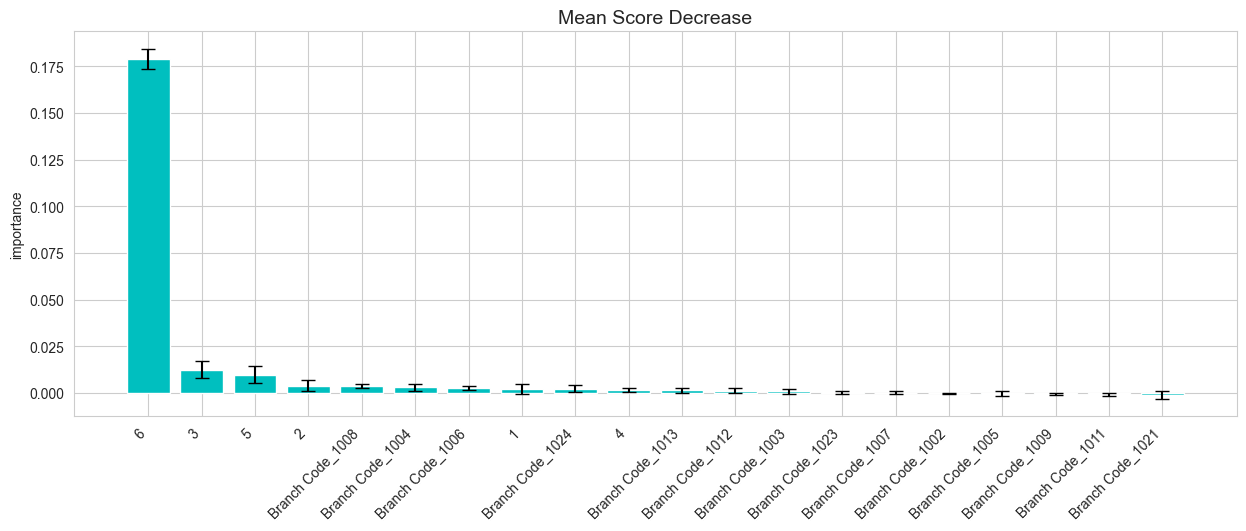

In [260]:
grid_result = grid.fit(X1_train, y1_train)
y1_pred = grid.predict(X1_test)

df_imp1 = mean_score_decrease(X1_train, y1_train, grid, plot=True, topk=20)

## Eksperimen 2

In [267]:
y2_pred = grid2.predict(X2_test)

C:\Users\gombe\OneDrive\Desktop\Prediksi Gagal Bayar\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [268]:
print("Accuracy:",metrics.accuracy_score(y2_test, y2_pred))
print("Recall:",metrics.recall_score(y2_test, y2_pred))
metrics.completeness_score

Accuracy: 0.7650947553988541
Recall: 0.4174917491749175


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [269]:
y2_pred_val =grid2.predict(X2_val)

C:\Users\gombe\OneDrive\Desktop\Prediksi Gagal Bayar\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [270]:
print("Accuracy:",metrics.accuracy_score(y2_val, y2_pred_val))
print("Recall:",metrics.recall_score(y2_val, y2_pred_val))
metrics.completeness_score

Accuracy: 0.6368205263853988
Recall: 0.26098191214470284


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

C:\Users\gombe\OneDrive\Desktop\Prediksi Gagal Bayar\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\gombe\OneDrive\Desktop\Prediksi Gagal Bayar\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\gombe\OneDrive\Desktop\Prediksi Gagal Bayar\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\gombe\OneDrive\Desktop\Prediksi Gagal Bayar\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\gombe\OneDrive\Desktop\Prediksi Gagal Bayar\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X ha

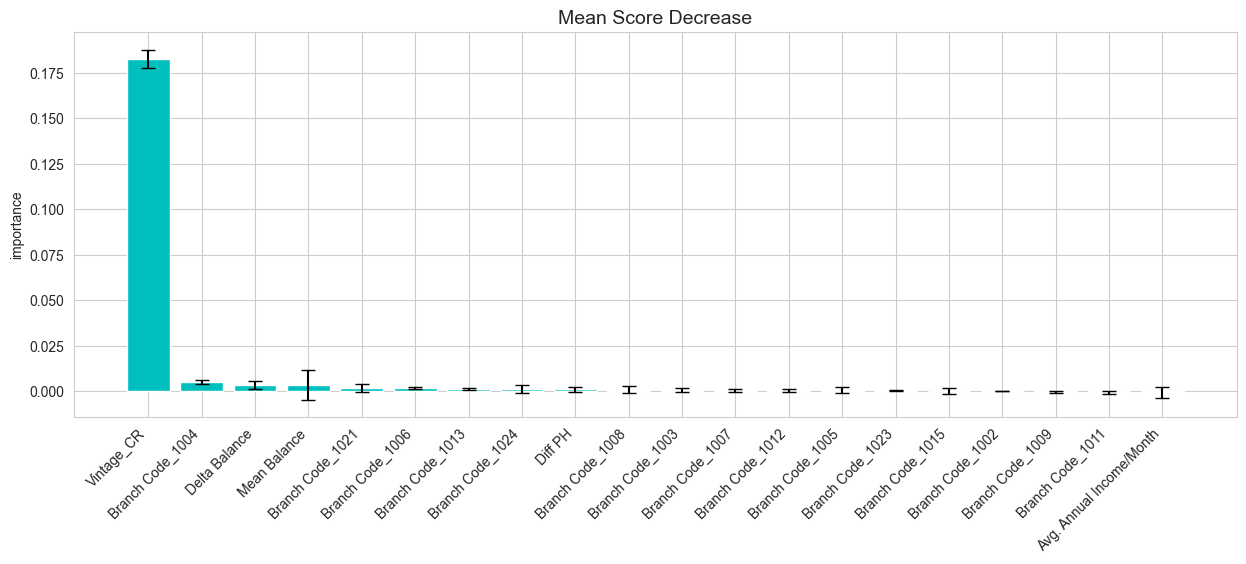

In [273]:
df_imp2 = mean_score_decrease(X2_train, y2_train, grid2, plot= True, topk=20)

# Gradient Boosting

# Eksperimen 1

In [274]:
y11_pred =GB_Grid.predict(X1_test)

In [275]:
print("Accuracy:",metrics.accuracy_score(y1_test, y11_pred))
print("Recall:",metrics.recall_score(y1_test, y11_pred))
metrics.completeness_score

Accuracy: 0.6862053768179814
Recall: 0.6056105610561056


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [276]:
y11_pred_val =GB_Grid.predict(X1_val)

In [277]:
print("Accuracy:",metrics.accuracy_score(y1_val, y11_pred_val))
print("Recall:",metrics.recall_score(y1_val, y11_pred_val))
metrics.completeness_score

Accuracy: 0.5933077635233435
Recall: 0.4485049833887043


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

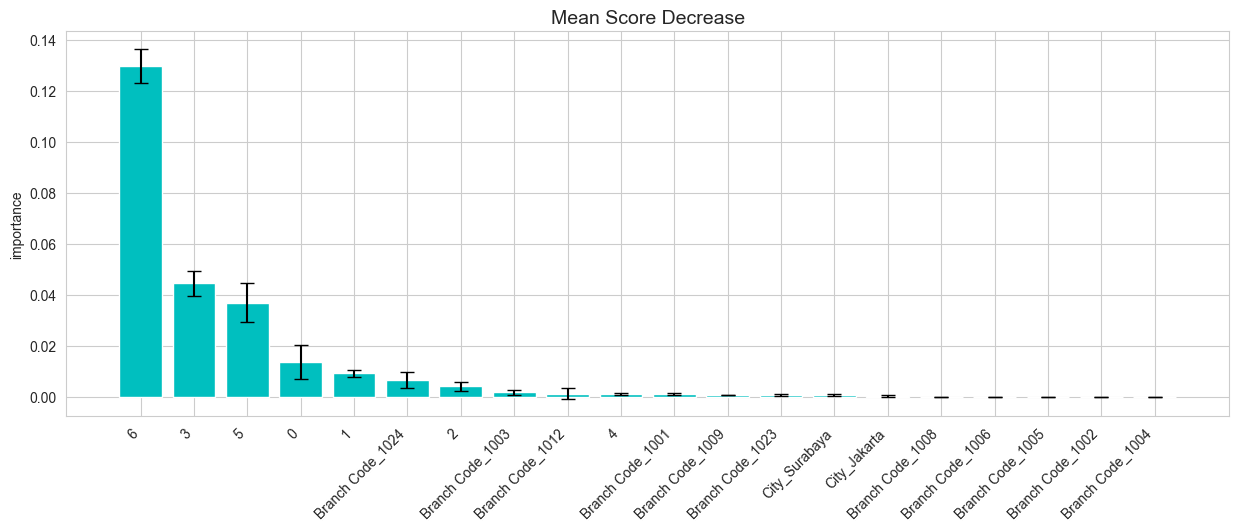

In [278]:
df_imp3 = mean_score_decrease(X1_train, y1_train, GB_Grid, plot= True, topk=20)

## Eksperimen 2

In [279]:
y22_pred =GB_Grid2.predict(X2_test)

In [280]:
print("Accuracy:",metrics.accuracy_score(y2_test, y22_pred))
print("Recall:",metrics.recall_score(y2_test, y22_pred))
metrics.completeness_score

Accuracy: 0.7192595857205818
Recall: 0.5066006600660066


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [282]:
y22_pred_val =GB_Grid2.predict(X2_val)

In [283]:
print("Accuracy:",metrics.accuracy_score(y2_val, y22_pred_val))
print("Recall:",metrics.recall_score(y2_val, y22_pred_val))
metrics.completeness_score

Accuracy: 0.6306044174051052
Recall: 0.38870431893687707


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

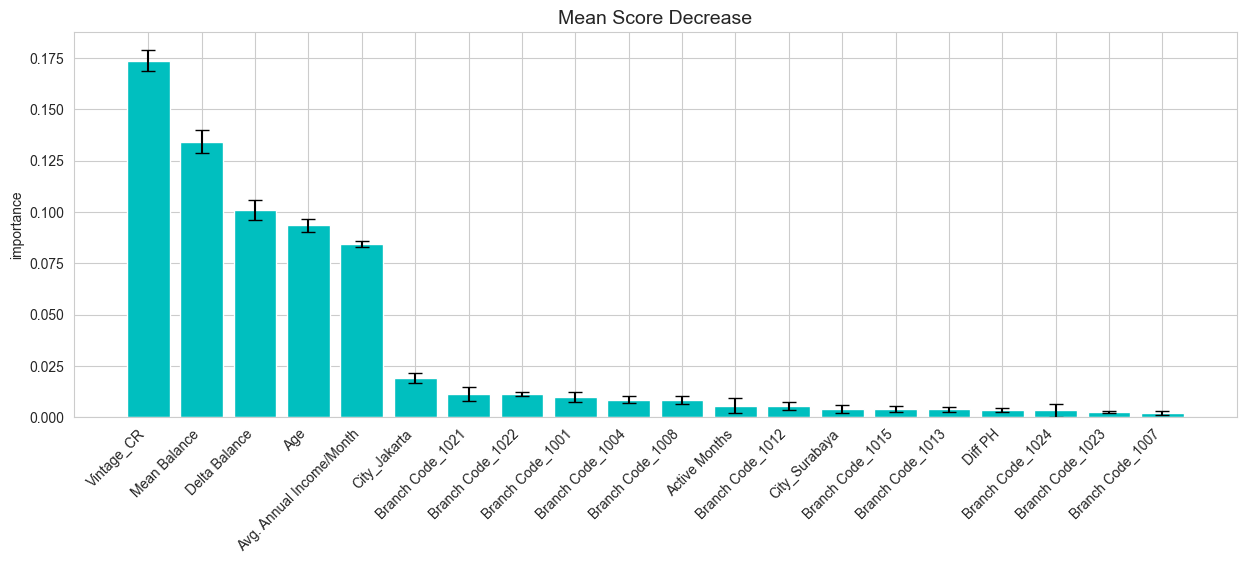

In [284]:
df_imp4 = mean_score_decrease(X2_train, y2_train, GB_Grid2, plot= True, topk=20)

# Random Forest

## Eksperimen 1

In [289]:
y12_pred =RF_Grid.predict(X1_test)

In [290]:
print("Accuracy:",metrics.accuracy_score(y1_test, y12_pred))
print("Recall:",metrics.recall_score(y1_test, y12_pred))
metrics.completeness_score

Accuracy: 0.8118113706478625
Recall: 0.3415841584158416


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [295]:
# Ubah semua nama kolom menjadi string
X1_val.columns = X1_val.columns.astype(str)
X1_train.columns = X1_train.columns.astype(str)

In [293]:
y12_pred_val =RF_Grid.predict(X1_val)

In [294]:
print("Accuracy:",metrics.accuracy_score(y1_val, y12_pred_val))
print("Recall:",metrics.recall_score(y1_val, y12_pred_val))
metrics.completeness_score

Accuracy: 0.7067848168231715
Recall: 0.3536360280546327


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

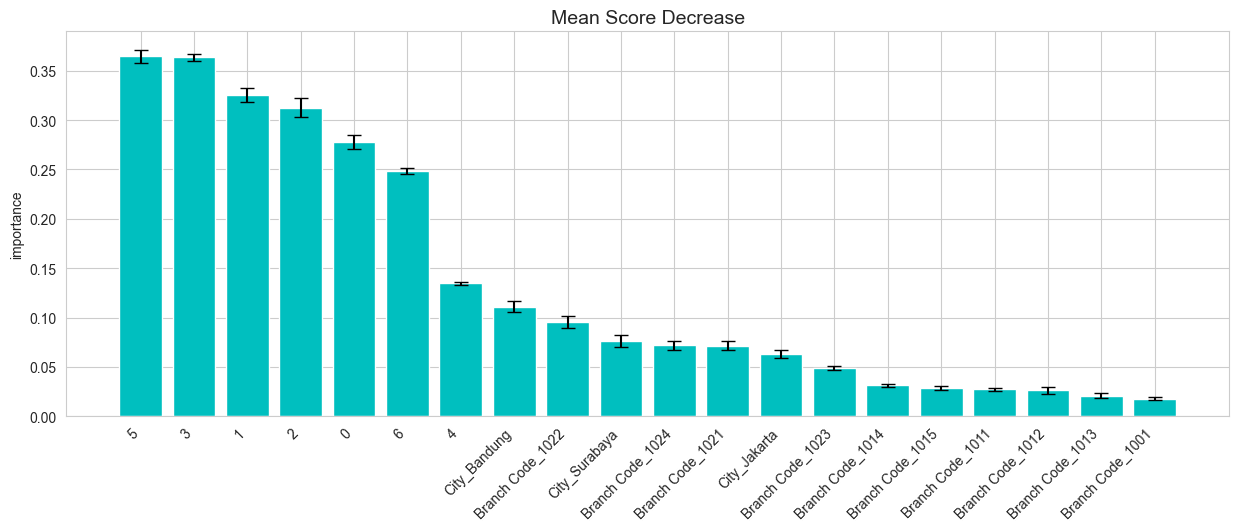

In [296]:
df_imp5 = mean_score_decrease(X1_train, y1_train, RF_Grid, plot= True, topk=20)

In [299]:
y21_pred =RF_Grid2.predict(X2_test)

In [300]:
print("Accuracy:",metrics.accuracy_score(y2_test, y21_pred))
print("Recall:",metrics.recall_score(y2_test, y21_pred))
metrics.completeness_score

Accuracy: 0.8113706478624945
Recall: 0.33003300330033003


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [301]:
y21_pred_val =RF_Grid2.predict(X2_val)

In [302]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y2_val, y21_pred_val))
print("Recall:",metrics.recall_score(y2_val, y21_pred_val))
metrics.completeness_score

Accuracy: 0.7004364502049993
Recall: 0.32595053525286083


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

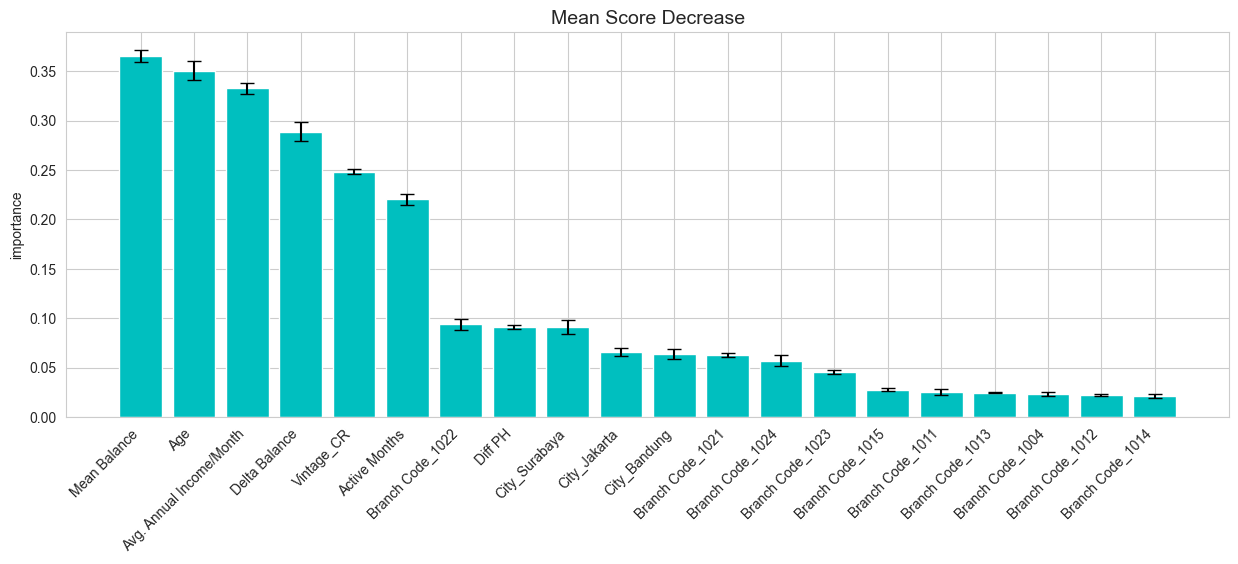

In [303]:
df_imp6 = mean_score_decrease(X2_train, y2_train, RF_Grid2, plot= True, topk=20)

# kesimpulan
Dari semua model, rata-rata memiliki accuray diatas 60% anmun memiliki recall di bawah 40%. Artinya, masih banyak nasabah yang sebenarnya berpotensi gagal bayar namun diperediksi tidak akan gagal bayar. Sehingga bisa disampaikan bahwa dalam literasi pembangunan model kali ini, objektif yang diinginkan masih belum dapat tercapai.

Solusi pengembangan kedepan yang bisa dilakukan di antaranya:
1. Memperbanyak sample (jumlah nasabah dgn asumsi dataset yang tersedia saat ni bukan total populasi nasabah).
2. Melakukan ovarsampling terhadap kelas minoritas (gagal bayar) agar pembangunan model tidak bias.
3. Memperluas horizon waktu.
4. Mencoba variasi variabel lainnya (menambahkan variabel baru, atau membuang variabel yang memiliki nilai importance rendah pada hasil terakhir)
5. Mencoba memperluas kombinasi hyperparameter dalam pembangunan model.
6. Mencoba algoritma supervised machine lainnya.
